In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
from keras import layers
from keras.applications import ResNet50, ResNet50V2
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.optimizers import Adam

In [48]:
batch_size = 64
img_height = 160
img_width = 160
data_dir = "../DFN_dataset/train_just1/"

In [49]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names

Found 40 files belonging to 2 classes.
Using 32 files for training.
Found 40 files belonging to 2 classes.
Using 8 files for validation.


In [50]:
AUTO = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTO)
val_ds = val_ds.cache().prefetch(buffer_size=AUTO)

In [51]:
num_classes = len(class_names) 

# Load the pre-trained ResNet50 model (without the top layer)
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = ResNet50V2(weights='imagenet',include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
base_model.trainable = False

# build the entire model
x = base_model.output
x = tf.keras.applications.resnet_v2.preprocess_input(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# global average pooling and dense layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 82, 82, 64)   0           ['conv1_conv[0][0]']       

In [52]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.top_k_categorical_accuracy])

model_history = model.fit(train_ds, validation_data=val_ds, epochs=100, verbose=1, batch_size=batch_size)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 1.0621 - accuracy: 0.5312 - top_k_categorical_accuracy: 1.0000 - val_loss: 10.2998 - val_accuracy: 0.6250 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 0s 74ms/step - loss: 16.3482 - accuracy: 0.4688 - top_k_categorical_accuracy: 1.0000 - val_loss: 10.6009 - val_accuracy: 0.3750 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 71ms/step - loss: 5.7155 - accuracy: 0.5938 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.5048 - val_accuracy: 0.7500 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 73ms/step - loss: 3.0051 - accuracy: 0.6250 - top_k_categorical_accuracy: 1.0000 - val_loss: 9.2033 - val_accuracy: 0.6250 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 73ms/step - loss: 10.4330 - accuracy: 0.4062 - top_k_categorical_accuracy

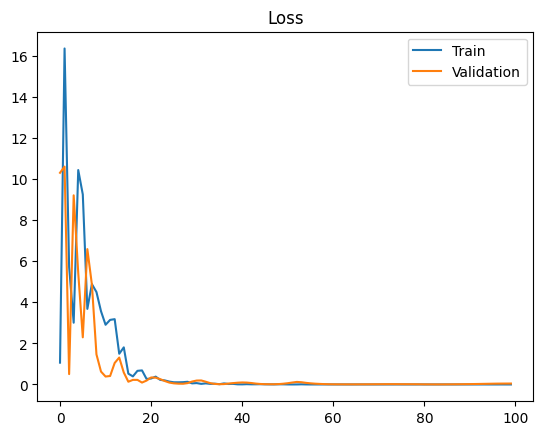

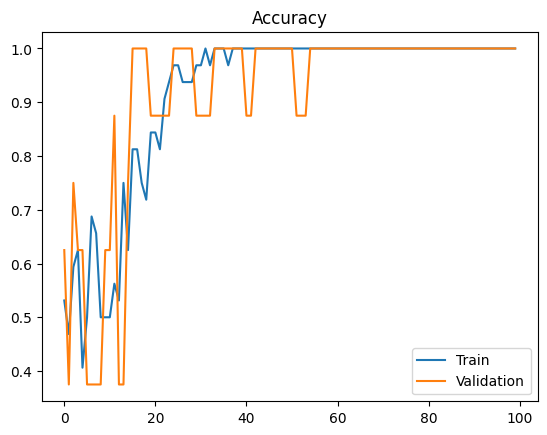

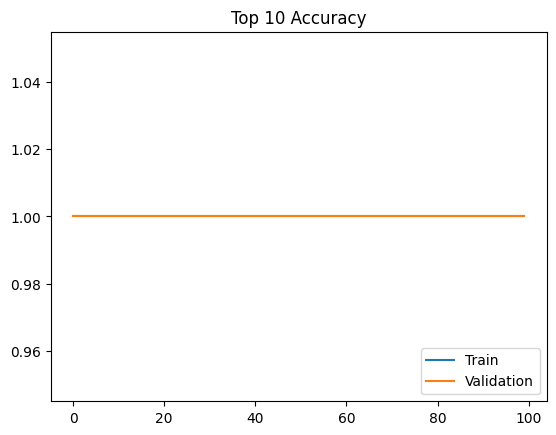

In [53]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

top5_acc_train_curve = model_history.history["top_k_categorical_accuracy"]
top5_acc_val_curve = model_history.history["val_top_k_categorical_accuracy"]
plt.plot(top5_acc_train_curve, label = "Train")
plt.plot(top5_acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Top 10 Accuracy") 
plt.show()

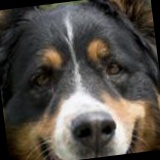

In [58]:
#Testing
# img = tf.keras.preprocessing.image.load_img(path="../photos/dogfacenet10/val/1/1307.0.jpg", target_size=(160,160))
img = tf.keras.preprocessing.image.load_img("../DFN_dataset/train_just1/000002/0002.jpg")
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img


In [59]:
# generate predictions for samples
predictions = model.predict(img_array)

# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)

# get top 10 predictions
top_10_predictions = np.argsort(predictions[0])[:-11:-1]

# top 10 predictions
for i in range(2):
    print(class_names[top_10_predictions[i]])

1/1 [==============================] - 0s 27ms/step
000002
000001
